In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from solvers import BurgersExplicit,BurgersFVM,BurgersImplicit,BurgersLaxWendroff,BurgersSpectral,GridArray,BurgersTVD, BurgersRiemann
import matplotlib.animation as animation
from IPython.display import HTML
from sklearn.gaussian_process.kernels import ExpSineSquared


In [4]:
def get_anim(u_sol):
    fig, ax = plt.subplots()
    line, = ax.plot(np.linspace(0,1,u_sol.shape[1]), u_sol[0])
    frames_to_show = np.linspace(0, u_sol.shape[0]-1, 100).astype(int)
    def animate(i):
        line.set_ydata(u_sol[i])
        return line,

    ani = animation.FuncAnimation(fig, animate, frames=frames_to_show, interval=100)
    return HTML(ani.to_jshtml())

# Introduction

This notebook is used to generate our data. We have coded several solvers in `solvers.py`, and will sample random initial conditions to get our dataset. 
The initial conditions are sampled as Gaussian process with the exponential sine kernel. Samples of this kernel are periodic and infinitely differentiable. 
To get a ground truth, we use one of the solvers with a much finer grid as reference. 

# Visualize one example of data generated

/Users/theobourdais/Library/CloudStorage/OneDrive-CaliforniaInstituteofTechnology/Caltech/Research/ModelAggregation/AggregatePDESolversBurgers/solvers.py:264: RuntimeWarning: overflow encountered in divide
  u[n - 1] * (np.roll(u[n - 1], -1) - np.roll(u[n - 1], 1)) / 2 / self.dx


nu=2.03e-03


100%|██████████| 79600/79600 [00:43<00:00, 1836.95it/s]


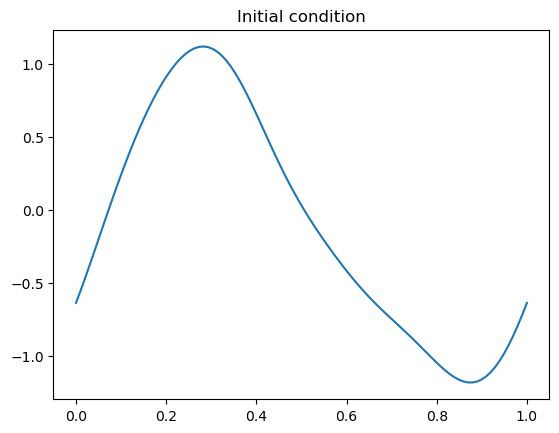

/Users/theobourdais/miniconda3/envs/torch/lib/python3.11/site-packages/matplotlib/image.py:463: RuntimeWarning: overflow encountered in scalar multiply
  newmin = vmid - dv * fact
/Users/theobourdais/miniconda3/envs/torch/lib/python3.11/site-packages/matplotlib/image.py:468: RuntimeWarning: overflow encountered in scalar multiply
  newmax = vmid + dv * fact


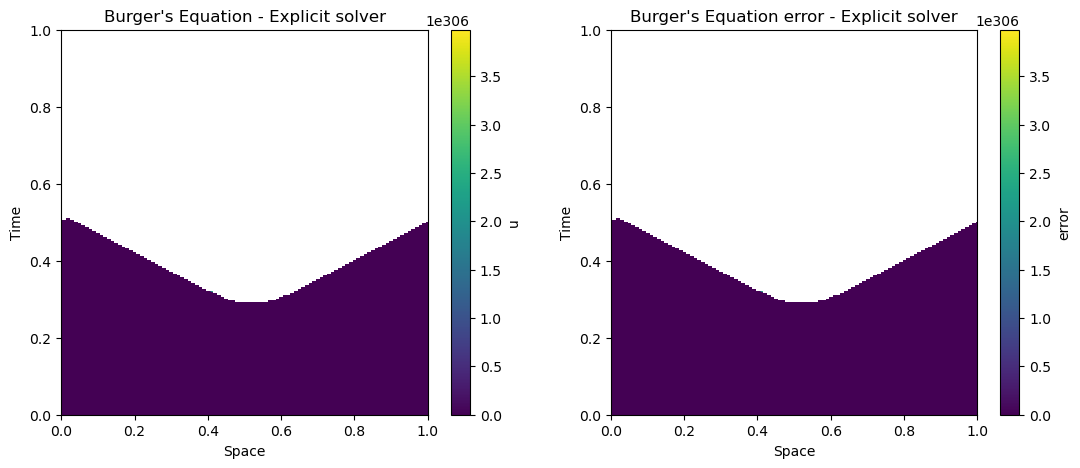

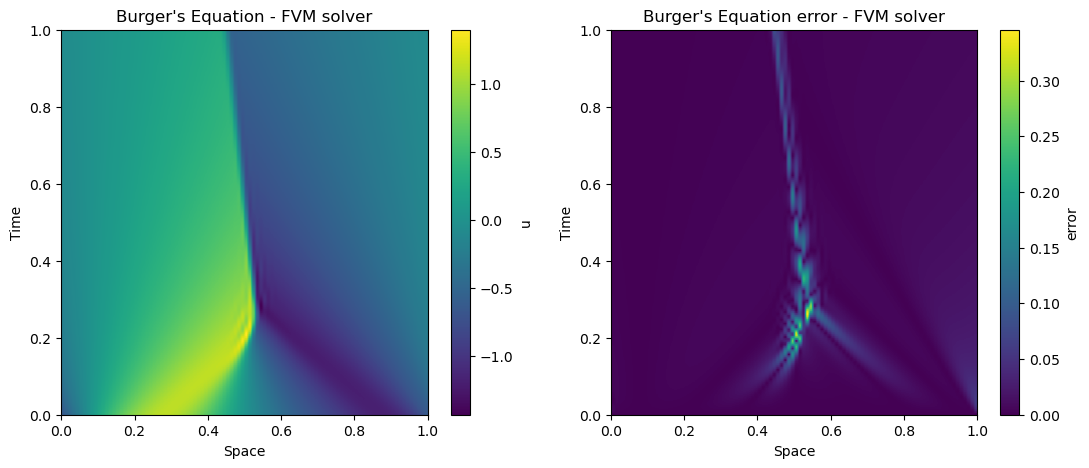

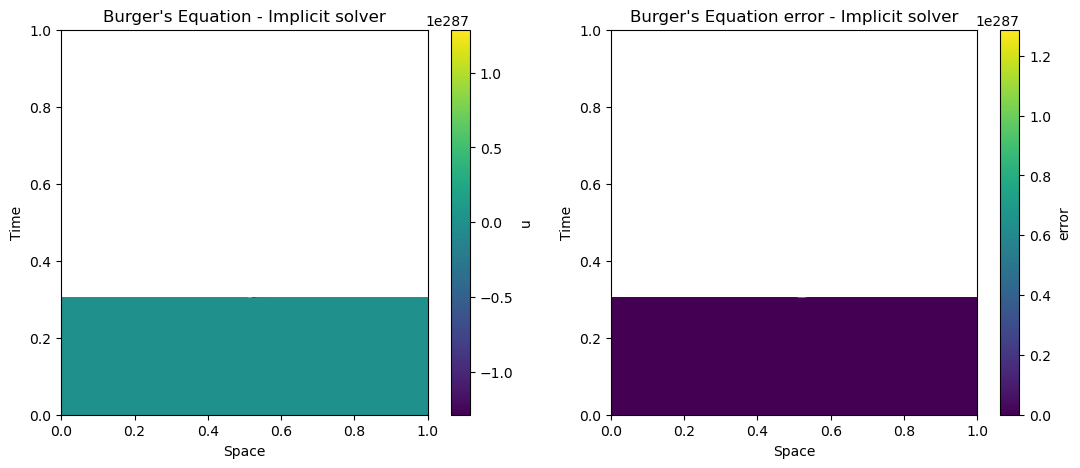

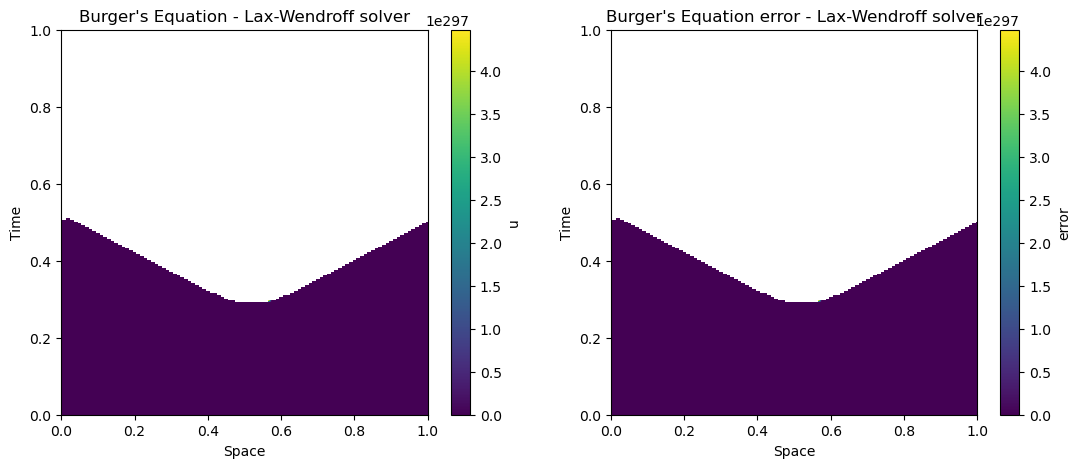

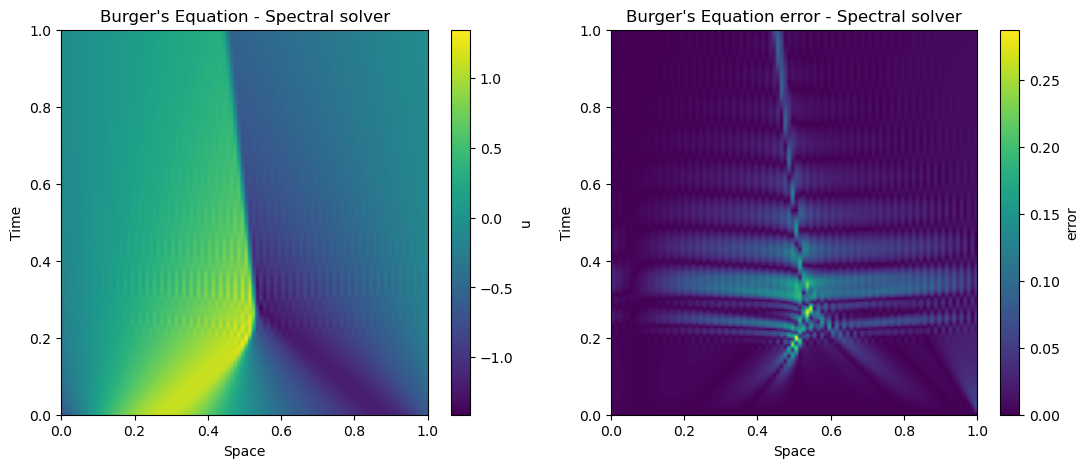

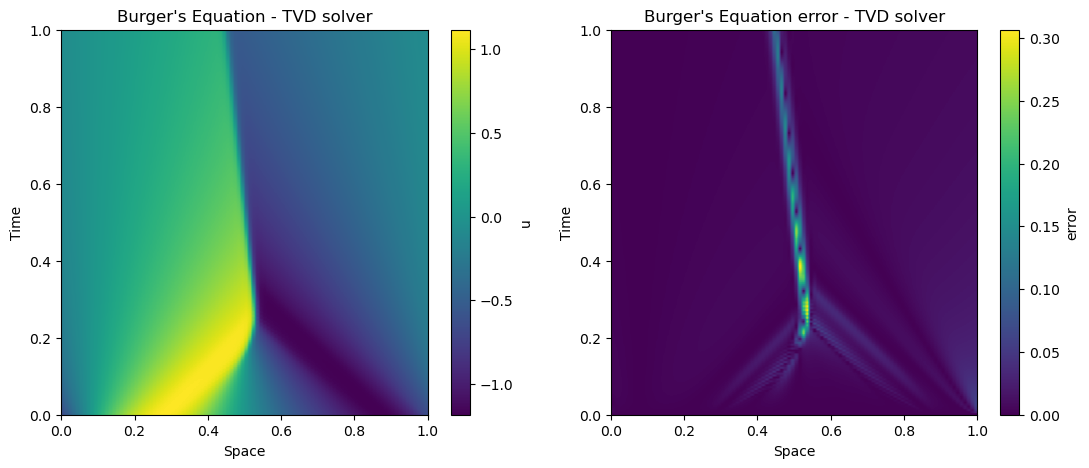

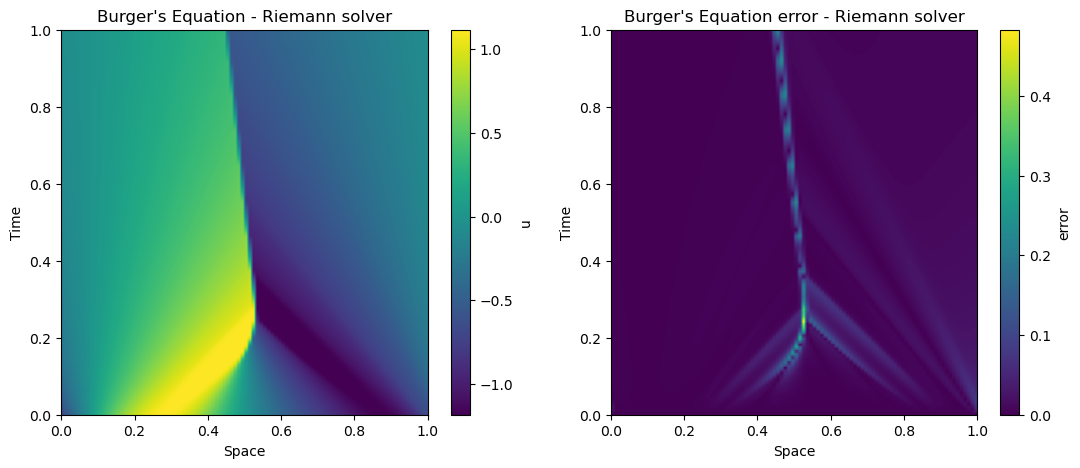

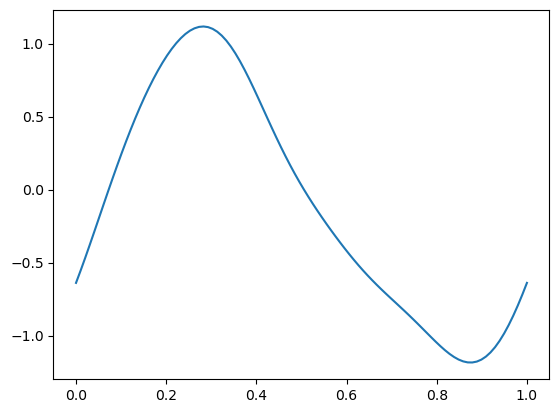

In [18]:


# Initial condition
nx = 100
nt=200
factor=20
new_nx=1+(nx-1)*factor
new_nt=1+(nt-1)*(factor)**2
T=1
dx=1/(nx-1)
dt=1/(nt-1)
nu=dx**2/dt*0.1
print(f'nu={nu:.2e}')

K_mat = ExpSineSquared(length_scale=1.5)(np.linspace(0,1,new_nx).reshape(-1,1))
cholesky = np.linalg.cholesky(K_mat + 1e-9*np.eye(new_nx))

sample = cholesky@np.random.normal(size=(new_nx))
grid_sample = GridArray(np.linspace(0, 1, new_nx),np.array([0]),sample[None,:])
sample_less_res = grid_sample[np.linspace(0, 1, nx),np.array([0])]

#nu = 1e-2
solvers=[
    BurgersExplicit(nx=nx,T=T),
    BurgersFVM(nx=nx,T=T),
    BurgersImplicit(nx=nx,T=T),
    BurgersLaxWendroff(nx=nx,T=T),
    BurgersSpectral(nx=nx,T=T),
    BurgersTVD(nx=nx,T=T),
    BurgersRiemann(nx=nx,T=T,order=1)
]
reference = BurgersSpectral(nx=new_nx,T=T,verbose=True)
names=['Explicit','FVM','Implicit','Lax-Wendroff','Spectral','TVD','Riemann']

def get_a_datapoint(u0,u0_less_res):
    u_sols=np.stack([s(u0_less_res,nt=nt,nu=nu) for s in solvers],axis=0)
    
    sol_ref=reference.solve(u0,nt=new_nt,nu=nu)
    sol_ref=GridArray(np.linspace(0, 1, new_nx),np.linspace(0,T,new_nt),sol_ref)
    sol_ref = sol_ref[np.linspace(0, 1, nx),np.linspace(0,T,u_sols.shape[1])]
    return u_sols,sol_ref

    




u_sols,sol_ref=get_a_datapoint(sample,sample_less_res)

plt.figure()
plt.plot(np.linspace(0,1,nx),sample_less_res)
plt.title('Initial condition')



#u_ref=reference.solve(u0,nt=u_sols.shape[1]*100)
# Plotting
for u_sol,name in zip(u_sols,names):
    #make figure with two subplots
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(13,5))
    img = ax1.imshow(u_sol, extent=[0, 1, 0, T], origin='lower', aspect='auto')
    plt.colorbar(img, ax=ax1,label='u')
    ax1.set_xlabel('Space')
    ax1.set_ylabel('Time')
    ax1.set_title(f'Burger\'s Equation - {name} solver')
    img2 = ax2.imshow(np.abs(u_sol-sol_ref), extent=[0, 1, 0, T], origin='lower', aspect='auto')
    plt.colorbar(img2, ax=ax2,label='error')
    ax2.set_xlabel('Space')
    ax2.set_ylabel('Time')
    ax2.set_title(f'Burger\'s Equation error - {name} solver')
plt.show()
#make an animation

get_anim(sol_ref)



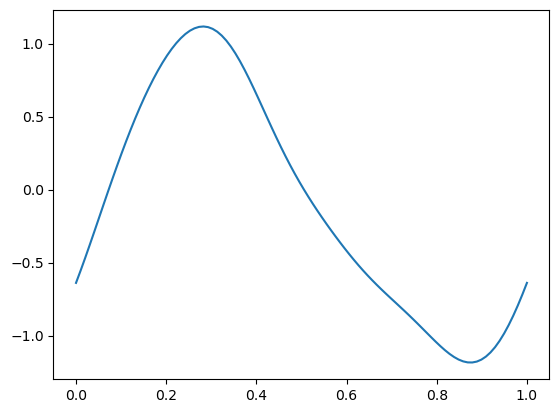

In [21]:
get_anim(u_sols[0])

# Sampling  a 1000 datapoints

In [243]:
np.random.seed(440)
import os
path='./data'
#create the directory specified by path
os.makedirs(path,exist_ok=True)
for i in range(1000):
    #check if sample already exists
    if os.path.exists(f'{path}/{i}.npz'):
        continue
    sample = cholesky@np.random.normal(size=(new_nx))
    grid_sample = GridArray(np.linspace(0, 1, new_nx),np.array([0]),sample[None,:])
    sample_less_res = grid_sample[np.linspace(0, 1, nx),np.array([0])]
    
    u_sols,sol_ref=get_a_datapoint(sample,sample_less_res)
    #save the tensors 
    np.savez(f'{path}/{i}',u0=sample_less_res,u_sols=u_sols,sol_ref=sol_ref)

100%|██████████| 79600/79600 [00:51<00:00, 1535.55it/s]
d:\OneDrive - California Institute of Technology\Caltech\Research\ModelAggregation\AggregatePDESolversBurgers\solvers.py:104: RuntimeWarning: overflow encountered in multiply
  - dt * u[n, :] * (u_right - u_left) / self.dx / 2
d:\OneDrive - California Institute of Technology\Caltech\Research\ModelAggregation\AggregatePDESolversBurgers\solvers.py:103: RuntimeWarning: invalid value encountered in subtract
  u[n, :]
d:\OneDrive - California Institute of Technology\Caltech\Research\ModelAggregation\AggregatePDESolversBurgers\solvers.py:105: RuntimeWarning: invalid value encountered in subtract
  + nu * dt / self.dx**2 * (u_right - 2 * u[n, :] + u_left)
d:\OneDrive - California Institute of Technology\Caltech\Research\ModelAggregation\AggregatePDESolversBurgers\solvers.py:105: RuntimeWarning: invalid value encountered in add
  + nu * dt / self.dx**2 * (u_right - 2 * u[n, :] + u_left)
d:\OneDrive - California Institute of Technology\Cal